Los dígitos del 0 al 4 son considerados "targets", los del 5 al 9 son "distractores".

El mensaje se genera como secuencia discreta usando Gumbel-Softmax.

Es fácil extender esto a juegos tipo "setref" con múltiples imágenes o a "concept" donde el emisor y receptor no ven los mismos inputs.

In [1]:
!pip install torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt


In [4]:
# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size = 10
message_len = 5
temperature = 1.0

In [5]:
# Gumbel-softmax
def gumbel_softmax(logits, tau=1.0):
    noise = torch.rand_like(logits)
    gumbel_noise = -torch.log(-torch.log(noise + 1e-10) + 1e-10)
    y = logits + gumbel_noise
    return F.softmax(y / tau, dim=-1)

# CNN feature extractor
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.flat = nn.Flatten()
        self.out = nn.Linear(64*7*7, 128)

    def forward(self, x):
        return self.out(self.flat(self.conv(x)))

# Emisor
class Sender(nn.Module):
    def __init__(self, vocab_size, msg_len):
        super().__init__()
        self.cnn = CNN()
        self.rnn = nn.GRU(256, 128, batch_first=True)
        self.proj = nn.Linear(128, vocab_size)
        self.msg_len = msg_len

    def forward(self, imgs, labels):
        feats = self.cnn(imgs)
        targets = feats[labels == 1].mean(0, keepdim=True)
        non_targets = feats[labels == 0].mean(0, keepdim=True)
        proto = torch.cat([targets, non_targets], dim=-1)
        proto = proto.repeat(imgs.size(0), self.msg_len, 1)  # un mensaje por imagen
        h, _ = self.rnn(proto)
        logits = self.proj(h)
        msg = gumbel_softmax(logits, tau=temperature)
        return msg

# Receptor
class Receiver(nn.Module):
    def __init__(self, vocab_size, msg_len):
        super().__init__()
        self.cnn = CNN()
        self.rnn = nn.GRU(vocab_size, 128, batch_first=True)
        self.fc = nn.Linear(128 + 128, 1)

    def forward(self, imgs, msg):
      feats = self.cnn(imgs)
      _, h = self.rnn(msg)
      h = h.squeeze(0)
      combined = torch.cat([feats, h], dim=1)
      return torch.sigmoid(self.fc(combined)).squeeze()

In [6]:
# Dataset
transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=64, shuffle=True)


🎯 Epoch 1, Loss: 0.0008


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128444 (\N{FRAME WITH PICTURE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


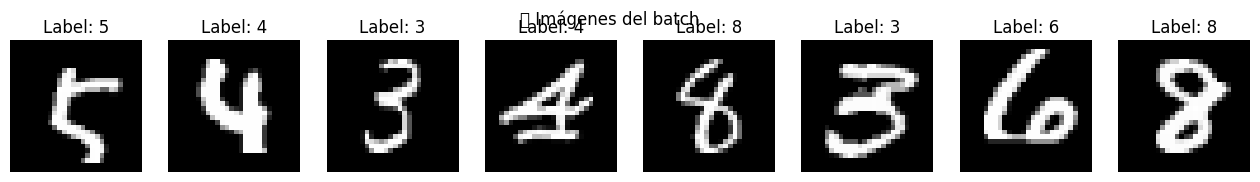


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 0 | Real: 0
[1] Pred: 1 | Real: 1
[2] Pred: 1 | Real: 1
[3] Pred: 1 | Real: 1
[4] Pred: 0 | Real: 0
[5] Pred: 1 | Real: 1
[6] Pred: 0 | Real: 0
[7] Pred: 0 | Real: 0

🎯 Epoch 2, Loss: 0.0033


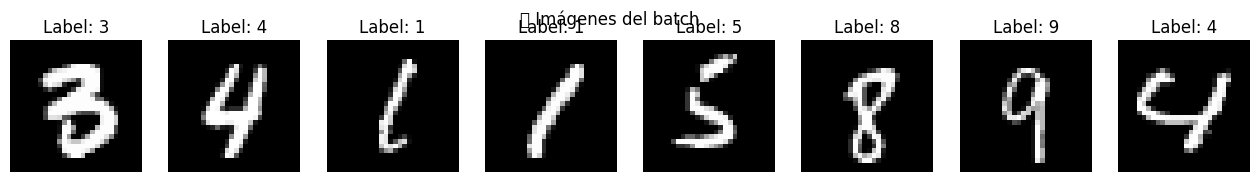


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 1 | Real: 1
[1] Pred: 1 | Real: 1
[2] Pred: 1 | Real: 1
[3] Pred: 1 | Real: 1
[4] Pred: 0 | Real: 0
[5] Pred: 0 | Real: 0
[6] Pred: 0 | Real: 0
[7] Pred: 1 | Real: 1

🎯 Epoch 3, Loss: 0.0011


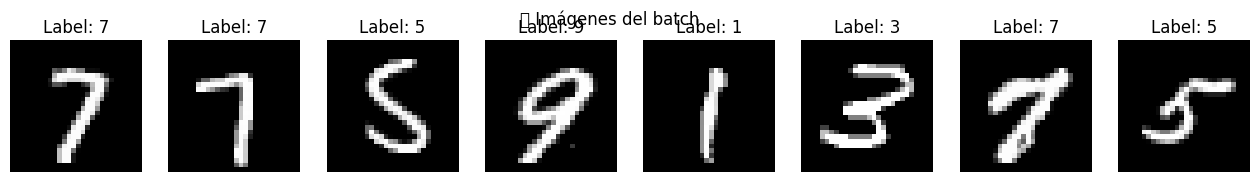


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 0 | Real: 0
[1] Pred: 0 | Real: 0
[2] Pred: 0 | Real: 0
[3] Pred: 0 | Real: 0
[4] Pred: 1 | Real: 1
[5] Pred: 1 | Real: 1
[6] Pred: 0 | Real: 0
[7] Pred: 0 | Real: 0

🎯 Epoch 4, Loss: 0.0002


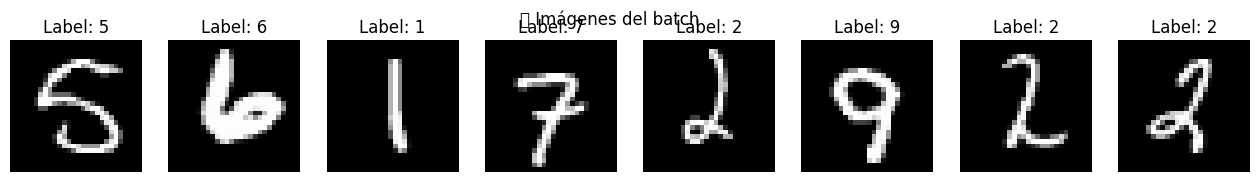


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 0 | Real: 0
[1] Pred: 0 | Real: 0
[2] Pred: 1 | Real: 1
[3] Pred: 0 | Real: 0
[4] Pred: 1 | Real: 1
[5] Pred: 0 | Real: 0
[6] Pred: 1 | Real: 1
[7] Pred: 1 | Real: 1

🎯 Epoch 5, Loss: 0.0120


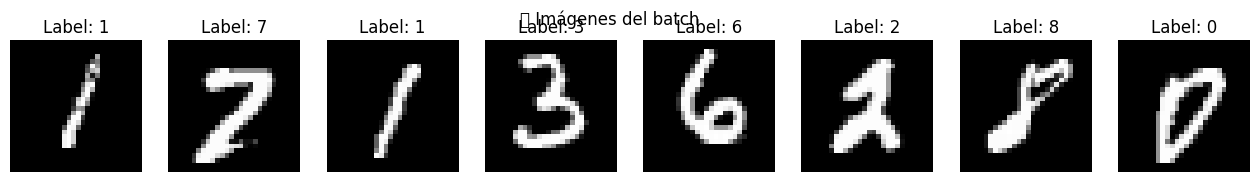


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 1 | Real: 1
[1] Pred: 0 | Real: 0
[2] Pred: 1 | Real: 1
[3] Pred: 1 | Real: 1
[4] Pred: 0 | Real: 0
[5] Pred: 1 | Real: 1
[6] Pred: 0 | Real: 0
[7] Pred: 1 | Real: 1

🎯 Epoch 6, Loss: 0.0093


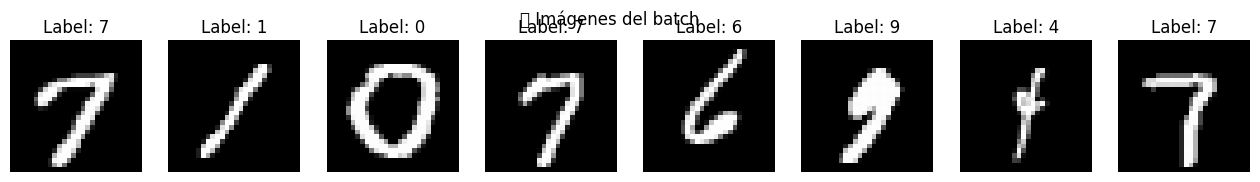


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 0 | Real: 0
[1] Pred: 1 | Real: 1
[2] Pred: 1 | Real: 1
[3] Pred: 0 | Real: 0
[4] Pred: 0 | Real: 0
[5] Pred: 0 | Real: 0
[6] Pred: 1 | Real: 1
[7] Pred: 0 | Real: 0

🎯 Epoch 7, Loss: 0.0001


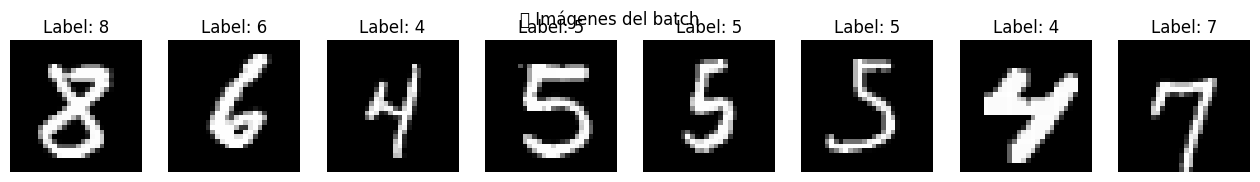


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 0 | Real: 0
[1] Pred: 0 | Real: 0
[2] Pred: 1 | Real: 1
[3] Pred: 0 | Real: 0
[4] Pred: 0 | Real: 0
[5] Pred: 0 | Real: 0
[6] Pred: 1 | Real: 1
[7] Pred: 0 | Real: 0

🎯 Epoch 8, Loss: 0.0025


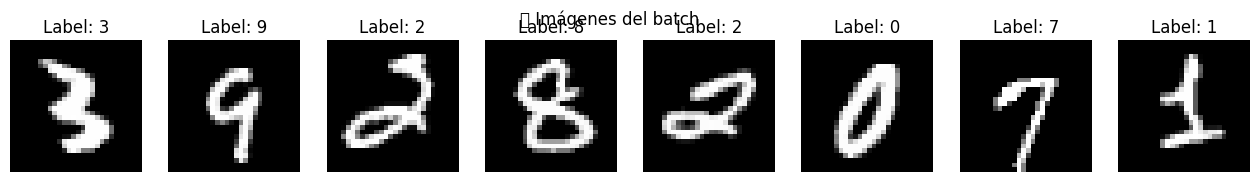


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 1 | Real: 1
[1] Pred: 0 | Real: 0
[2] Pred: 1 | Real: 1
[3] Pred: 0 | Real: 0
[4] Pred: 1 | Real: 1
[5] Pred: 1 | Real: 1
[6] Pred: 0 | Real: 0
[7] Pred: 1 | Real: 1

🎯 Epoch 9, Loss: 0.0001


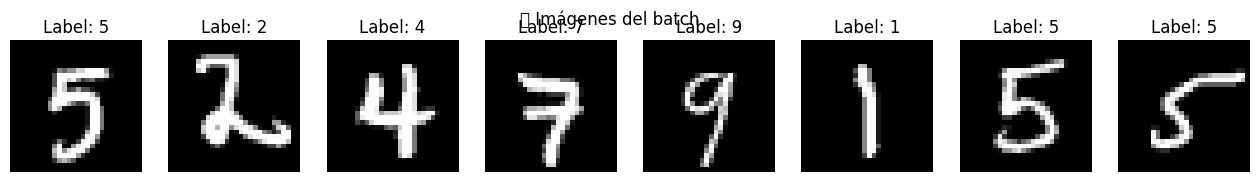


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 0 | Real: 0
[1] Pred: 1 | Real: 1
[2] Pred: 1 | Real: 1
[3] Pred: 0 | Real: 0
[4] Pred: 0 | Real: 0
[5] Pred: 1 | Real: 1
[6] Pred: 0 | Real: 0
[7] Pred: 0 | Real: 0

🎯 Epoch 10, Loss: 0.0003


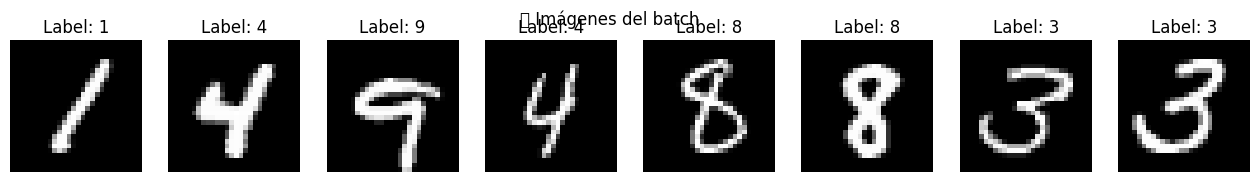


📩 Mensajes del emisor (tokens):
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicciones del receptor:
[0] Pred: 1 | Real: 1
[1] Pred: 1 | Real: 1
[2] Pred: 0 | Real: 0
[3] Pred: 1 | Real: 1
[4] Pred: 0 | Real: 0
[5] Pred: 0 | Real: 0
[6] Pred: 1 | Real: 1
[7] Pred: 1 | Real: 1


In [12]:
# Entrenamiento
for epoch in range(10):
    for batch_idx, (images, labels) in enumerate(loader):
        images, labels = images.to(device), labels.to(device)
        binary_labels = (labels < 5).long()

        # Forward pass
        msg = sender(images, binary_labels)
        preds = receiver(images, msg)

        # Cálculo de pérdida y optimización
        loss = F.binary_cross_entropy(preds, binary_labels.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Mostrar progreso
        if batch_idx == 0:
            print(f"\n🎯 Epoch {epoch+1}, Loss: {loss.item():.4f}")

            # Mostrar imágenes
            n = 8
            fig, axes = plt.subplots(1, n, figsize=(n*2, 2))
            for i in range(n):
                img = images[i].cpu().squeeze()
                axes[i].imshow(img, cmap='gray')
                axes[i].set_title(f"Label: {labels[i].item()}")
                axes[i].axis('off')
            plt.suptitle("🖼 Imágenes del batch")
            plt.show()

            # Mostrar mensajes discretizados
            print("\n📩 Mensajes del emisor (tokens):")
            msg_hard = msg.argmax(dim=-1)
            for i in range(n):
                tokens = " ".join([str(tok.item()) for tok in msg_hard[i]])
                print(f"[{i}] {tokens}")

            # Mostrar predicciones vs ground truth
            print("\n✅ Predicciones del receptor:")
            preds_binary = (preds > 0.5).long()
            for i in range(n):
                print(f"[{i}] Pred: {preds_binary[i].item()} | Real: {binary_labels[i].item()}")

EPOCA:  0


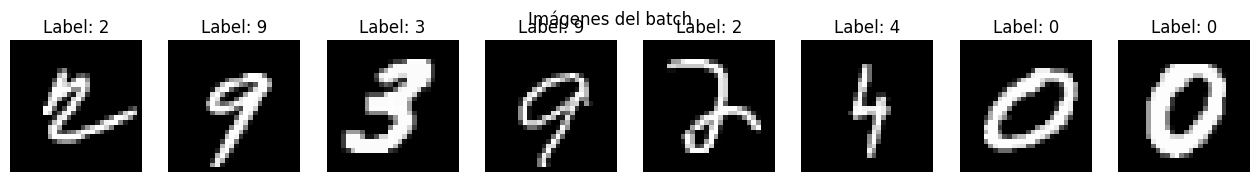


📩 Mensajes del emisor:
[0] 6 4 1 0 8
[1] 6 8 5 0 4
[2] 9 3 3 1 9
[3] 6 6 6 0 4
[4] 8 5 2 9 6
[5] 3 6 1 1 6
[6] 8 0 7 1 9
[7] 6 5 6 5 3

✅ Predicción del receptor (1=target):
[0] Predicho: 1 | Real: 1
[1] Predicho: 0 | Real: 0
[2] Predicho: 1 | Real: 1
[3] Predicho: 0 | Real: 0
[4] Predicho: 1 | Real: 1
[5] Predicho: 1 | Real: 1
[6] Predicho: 1 | Real: 1
[7] Predicho: 1 | Real: 1
Epoch 1: Loss 0.0208
EPOCA:  1
Epoch 2: Loss 0.0044
EPOCA:  2


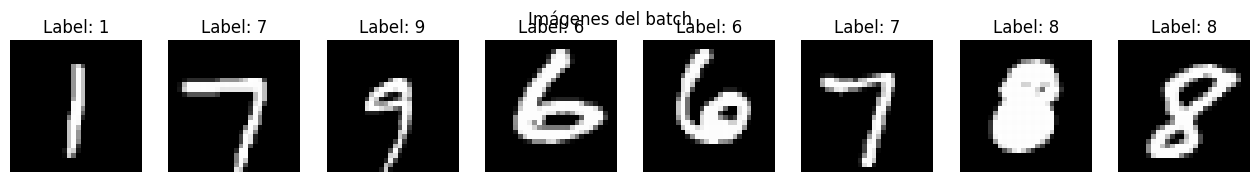


📩 Mensajes del emisor:
[0] 2 9 8 1 4
[1] 4 2 6 9 4
[2] 4 4 9 8 3
[3] 3 8 2 9 8
[4] 3 7 2 5 0
[5] 2 2 0 9 3
[6] 2 4 5 7 7
[7] 5 6 5 4 8

✅ Predicción del receptor (1=target):
[0] Predicho: 1 | Real: 1
[1] Predicho: 0 | Real: 0
[2] Predicho: 0 | Real: 0
[3] Predicho: 0 | Real: 0
[4] Predicho: 0 | Real: 0
[5] Predicho: 0 | Real: 0
[6] Predicho: 0 | Real: 0
[7] Predicho: 0 | Real: 0
Epoch 3: Loss 0.0268
EPOCA:  3
Epoch 4: Loss 0.0014
EPOCA:  4


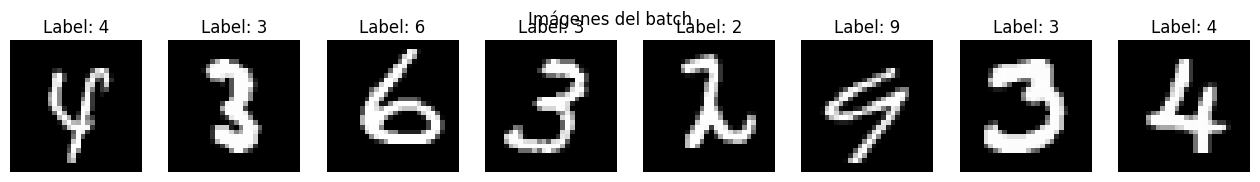


📩 Mensajes del emisor:
[0] 0 1 9 8 5
[1] 4 8 3 6 6
[2] 6 5 1 7 2
[3] 8 4 8 7 1
[4] 5 2 7 4 6
[5] 6 6 4 4 3
[6] 5 2 4 7 2
[7] 1 4 6 5 9

✅ Predicción del receptor (1=target):
[0] Predicho: 1 | Real: 1
[1] Predicho: 1 | Real: 1
[2] Predicho: 0 | Real: 0
[3] Predicho: 1 | Real: 1
[4] Predicho: 1 | Real: 1
[5] Predicho: 0 | Real: 0
[6] Predicho: 1 | Real: 1
[7] Predicho: 1 | Real: 1
Epoch 5: Loss 0.0342
EPOCA:  5
Epoch 6: Loss 0.0038
EPOCA:  6


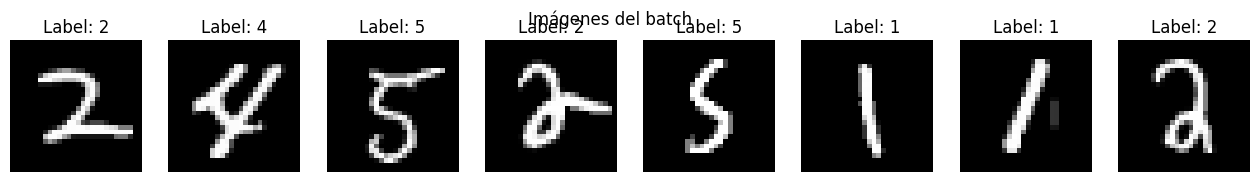


📩 Mensajes del emisor:
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicción del receptor (1=target):
[0] Predicho: 1 | Real: 1
[1] Predicho: 1 | Real: 1
[2] Predicho: 0 | Real: 0
[3] Predicho: 1 | Real: 1
[4] Predicho: 0 | Real: 0
[5] Predicho: 1 | Real: 1
[6] Predicho: 1 | Real: 1
[7] Predicho: 1 | Real: 1
Epoch 7: Loss 0.0111
EPOCA:  7
Epoch 8: Loss 0.0043
EPOCA:  8


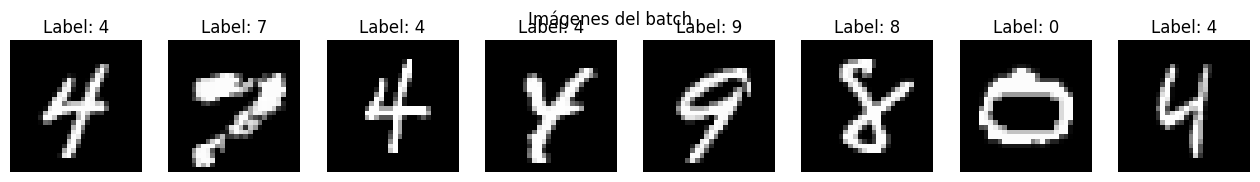


📩 Mensajes del emisor:
[0] 4 4 4 4 4
[1] 4 4 4 4 4
[2] 4 4 4 4 4
[3] 4 4 4 4 4
[4] 4 4 4 4 4
[5] 4 4 4 4 4
[6] 4 4 4 4 4
[7] 4 4 4 4 4

✅ Predicción del receptor (1=target):
[0] Predicho: 1 | Real: 1
[1] Predicho: 0 | Real: 0
[2] Predicho: 1 | Real: 1
[3] Predicho: 1 | Real: 1
[4] Predicho: 0 | Real: 0
[5] Predicho: 0 | Real: 0
[6] Predicho: 1 | Real: 1
[7] Predicho: 1 | Real: 1
Epoch 9: Loss 0.0044
EPOCA:  9
Epoch 10: Loss 0.0031


In [11]:
# # Entrenamiento
# sender = Sender(vocab_size, message_len).to(device)
# receiver = Receiver(vocab_size, message_len).to(device)
# optimizer = torch.optim.Adam(list(sender.parameters()) + list(receiver.parameters()), lr=1e-3)

# for epoch in range(10):
#     print("EPOCA: ", epoch)
#     for images, labels in loader:
#         images, labels = images.to(device), labels.to(device)
#         # Clasificación binaria: objetivo si dígito < 5
#         binary_labels = (labels < 5).long()
#         msg = sender(images, binary_labels)
#         preds = receiver(images, msg)
#         loss = F.binary_cross_entropy(preds, binary_labels.float())
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         # print(f"Imagen: {type(images)}, Label {type(labels)}, Mensaje: {type(msg)}, Predicción: {type(preds)}")

#     #
#     # if epoch%2 == 0:
#     #   with torch.no_grad():
#     #       # Visualiza primeras 8 imágenes
#     #       n = 8
#     #       fig, axes = plt.subplots(1, n, figsize=(n*2, 2))
#     #       for i in range(n):
#     #           img = images[i].cpu().squeeze()
#     #           axes[i].imshow(img, cmap='gray')
#     #           axes[i].set_title(f"Label: {labels[i].item()}")
#     #           axes[i].axis('off')
#     #       plt.suptitle("Imágenes del batch")
#     #       plt.show()

#     #       # Mensaje del emisor
#     #       print("\n📩 Mensajes del emisor:")
#     #       msg_hard = msg.argmax(dim=-1)  # (B, msg_len)
#     #       for i in range(n):
#     #           tokens = " ".join([str(tok.item()) for tok in msg_hard[i]])
#     #           print(f"[{i}] {tokens}")

#     #       # Predicciones del receptor
#     #       print("\n✅ Predicción del receptor (1=target):")
#     #       preds_binary = (preds > 0.5).long()
#     #       for i in range(n):
#     #           print(f"[{i}] Predicho: {preds_binary[i].item()} | Real: {binary_labels[i].item()}")


#     print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")